# Shifted data HyperParameter Optimization Without Labels (SHPOWL)

In real world machine learning applications we often see data shifts that impact the predictive performance of a trained ML model. 

These shifts can happen in the covariates (the features consumed by the ML model), that's called a covariate shift, or in the label distributions, that's called a label shift. 

Detecting these shifts is an active area of research (see [Lipton, Wang and Smola, ICML 2018](https://arxiv.org/pdf/1802.03916.pdf), [Rabanser, Günnemann and Lipton, NIPS 2019](http://arxiv.org/abs/1810.11953), [Schelter, Rukat and Biessmann, SIGMOD 2020](https://ssc.io/publication/learning-to-validate-the-predictions-of-black-box-classifiers-on-unseen-data-sigmod/)). 

But what do you do if you have detected a shift? 

The usual answer is: get more data with labels that looks similar to that shifted data. 

Another answer is: build more robust models, that can for instance deal with covariate [Bickel, Brueckner and Scheffer](http://jmlr.csail.mit.edu/papers/volume10/bickel09a/bickel09a.pdf), or that use semi-supervised learning [Zhou et al, 2018](https://arxiv.org/abs/1812.05313).

The approach we take here is slightly different. We propose to do *model selection at test time*, meaning without having access to ground truth labels. 

We follow the approach in [Schelter, Rukat and Biessmann, SIGMOD 2020](https://ssc.io/publication/learning-to-validate-the-predictions-of-black-box-classifiers-on-unseen-data-sigmod/) and use their pipeline performance prediction (PPP) model to predict the predictive performance of a model at test time to pick the best model candidate. 

In the below toy data example, we use KNearestNeighbors and grid search to demonstrate the approach.

In [95]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

def plot_decision_surface(clf, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10, edgecolor='k')
    plt.ylim([-3,3])


def generate_data(N=100, noise=1):
    x = np.linspace(-np.pi, 2*np.pi,N//2)
    x_1 = np.cos(x)+1 + np.random.randn(N//2)*noise
    x_2 = np.cos(x)-1 + np.random.randn(N//2)*noise
    X = np.vstack([np.hstack([x,x]),np.hstack([x_1,x_2])]).T
    y = np.hstack([np.ones(N//2),np.zeros(N//2)])
    return X, y

# Toy Data Example

Legend: 
- black/white are two classes
- small circles: train data with fixed noise level
- large circles: test data with varying noise level (that's the data shift)

A KNearestNeighbor model is trained with three different k's. Each column is a different k.

To emulate the data shift in the test data, different amounts of noise are added to the generated data. Each row is a different noise level. 

While the pipeline performance prediction does not perform great in terms of predicting the exact test data accuracy, it does get the ranking w.r.t. the relevant hyperparameter k right. 

This means that the optimal k is, in this not-representative toy data example, found using PPP. 

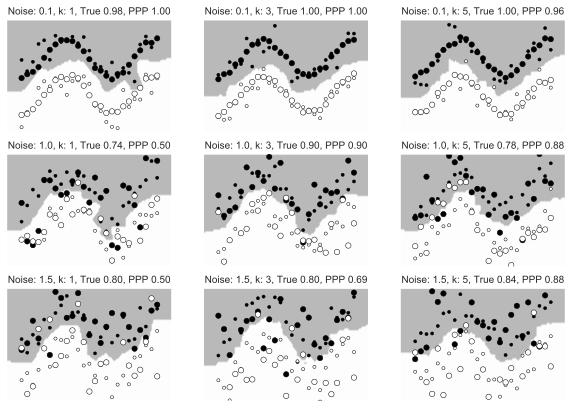

In [103]:
from jenga.cleaning.ppp import PipelineWithPPP
import pandas as pd

neighbors = [1, 3, 5]
noise = [.1, 1, 1.5]

N = 50
np.random.seed(0)

plt.figure(figsize=[10,7])
for inoise, nnoise in enumerate(noise):
    for inn, nneighbors in enumerate(neighbors):
        X_train, y_train = generate_data(N=N, noise=.5)
        X_test, y_test = generate_data(N=N, noise=nnoise)
        plt.subplot(len(noise), len(neighbors), inoise * (len(neighbors)) + inn + 1)
        clf = KNeighborsClassifier(n_neighbors=nneighbors).fit(X_train,y_train)
        plot_decision_surface(clf, X_train, y_train)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=30, edgecolor='k')
        plt.axis('off')
        ppp = PipelineWithPPP(clf, 
                      numeric_columns=[1], 
                      categorical_columns=[],
                      num_repetitions=10,
                      perturbation_fractions=np.arange(0,1,4)
                     )

        ppp.fit_ppp(pd.DataFrame(X_train), y_train)
        plt.title(f'Noise: {nnoise:1.1f}, k: {nneighbors}, True {clf.score(X_test, y_test):0.2f}, PPP {ppp.predict_ppp(X_test):.2f}', fontdict={'fontsize':10})
